# Kaggle Shelter Animal Outcomes

https://www.kaggle.com/c/shelter-animal-outcomes

The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake.

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer.

The train and test data are randomly split.


In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv.gz', parse_dates=['DateTime'], index_col='AnimalID')
test = pd.read_csv('test.csv.gz', parse_dates=['DateTime'], index_col='ID')

In [394]:
import re

from sklearn.preprocessing import LabelEncoder

class FeatureExtractor(object):
    DAYS_OF_WEEK = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    COLORS = ['Black', 'White', 'Brown', 'Brown']
    def __init__(self):
        self._label_encoders = dict(
            AnimalType = LabelEncoder(),
            Sex = LabelEncoder(),
            Intact = LabelEncoder(),
            Breed = LabelEncoder(),
            Color = LabelEncoder(),
        )
        self._outcomesubtype_dist = dict()
        self._age_median = None
        self._color_dist = None
    
    def fit(self, X):
        self._label_encoders['AnimalType'].fit(X['AnimalType'])
        
        self._label_encoders['Sex'].fit(X['SexuponOutcome'].map(self._extract_sex))
        self._label_encoders['Intact'].fit(X['SexuponOutcome'].map(self._extract_intact))
        
        X['AgeInDays'] = X['AgeuponOutcome'].map(self._extract_age)
        self._age_median = X.groupby('AnimalType')['AgeInDays'].median()
        X = X.drop(['AgeInDays'], axis=1)
        
        self._label_encoders['Breed'].fit(X['Breed'])
        for outcomesubtype in X['OutcomeSubtype'].unique():
            self._outcomesubtype_dist[outcomesubtype] = X[X['OutcomeSubtype'] == outcomesubtype]['Breed'].value_counts(normalize=True)
        
        self._color_dist = X['Color'].value_counts(normalize=True)
        self._label_encoders['Color'].fit(X['Color'])
        
        self._name_dist = X['Name'].value_counts(normalize=True)
 
        return self
    
    def transform(self, X):
        result = pd.DataFrame(index=X.index)

        result['HasName'] = (~X['Name'].isnull()).astype(int)
        result['NamePopularity'] = X['Name'].dropna().map(lambda name: self._name_dist[name]).fillna(0)
        result['NameLength'] = X['Name'].dropna().map(lambda name: len(name)).fillna(0)
        
        result['AnimalType'] = self._label_encoders['AnimalType'].transform(X['AnimalType'])

        result['Sex'] = self._label_encoders['Sex'].transform(X['SexuponOutcome'].map(self._extract_sex))
        result['Intact'] = self._label_encoders['Intact'].transform(X['SexuponOutcome'].map(self._extract_intact))

        result['AgeuponOutcome'] = X['AgeuponOutcome'].map(self._extract_age)
        
        result['UnknownAge'] = X['AgeuponOutcome'].isnull().astype(int)
        for animaltype in self._label_encoders['AnimalType'].classes_:
            result.loc[X['AnimalType'] == animaltype, 'AgeuponOutcome'] = result[X['AnimalType'] == animaltype]['AgeuponOutcome'].fillna(self._age_median[animaltype])

        result['Year'] = X['DateTime'].map(lambda dt: dt.year)
        result['Quarter'] = X['DateTime'].map(lambda dt: dt.quarter)
        result['Month'] = X['DateTime'].map(lambda dt: dt.month)
        result['Day'] = X['DateTime'].map(lambda dt: dt.day)
        result['DayOfWeek'] = X['DateTime'].map(lambda dt: dt.dayofweek)
        result['Hour'] = X['DateTime'].map(lambda dt: dt.hour)
        result['Minute'] = X['DateTime'].map(lambda dt: dt.minute)
        result[self.DAYS_OF_WEEK] = pd.get_dummies(result['DayOfWeek'].map(
                                    lambda d: self.DAYS_OF_WEEK[d]), columns=self.DAYS_OF_WEEK
                            )[self.DAYS_OF_WEEK]
        
        result['BreedMix'] = X['Breed'].map(lambda b: 'Mix' in b).astype(int)
        result['Longhair'] = X['Breed'].map(lambda b: 'Longhair' in b).astype(int)
        result['Shorthair'] = X['Breed'].map(lambda b: 'Shorthair' in b).astype(int)
        result['Breed'] = self._label_encoders['Breed'].transform(X['Breed'])
        for outcomesubtype, dist in self._outcomesubtype_dist.items():
            result[outcomesubtype] = X['Breed'].map(lambda breed: dist.get(breed, 0))
        
        result['ColorPopularity'] = X['Color'].map(lambda c: self._color_dist[c])
        result['SimpleColor'] = X['Color'].map(lambda color: not '/' in color).astype(int)
        result['Color'] = self._label_encoders['Color'].transform(X['Color'])
        result['Tabby'] = X['Color'].map(lambda color: 'Tabby' in color).astype(int)
        return result
    
    @classmethod
    def _extract_sex(cls, sex):
        if pd.isnull(sex):
            return 'Unknown'
        if 'Female' in sex:
            return 'Female'
        if 'Male' in sex:
            return 'Male'
        return 'Unknown'
    
    @classmethod
    def _extract_intact(cls, sex):
        if pd.isnull(sex):
            return 'Unknown'
        if 'Intact' in sex:
            return 'Intact'
        if 'Spayed' in sex or 'Neutered' in sex:
            return 'Spayed'
        return 'Unknown'
    
    @classmethod
    def _extract_age(cls, age):
        if pd.isnull(age):
            return np.nan
        days_in = {
            'day': 1,
            'week': 7,
            'month': 30,
            'year': 365,
        }

        m = re.match('(?P<num>\d+)\s+(?P<period>\w+)', age)
        num = int(m.group('num'))
        period = m.group('period')
        if period.endswith('s'):
            period = period[:-1]
        return num * days_in[period]

In [448]:
outcometype_encoder = LabelEncoder().fit(train['OutcomeType'])
feature_extractor = FeatureExtractor().fit(train.append(test))

features = [
    'AgeuponOutcome',
#     'UnknownAge',
    'AnimalType',
    'Sex',
    'Intact',
    'HasName',
    'Year',
    'Month',
    'Quarter',
    'Hour',
    'Minute',
#     'BreedMix',
#     'BreedPopularity',
#     'Longhair',
#     'Shorthair',
#     'ColorPopularity',
#     'SimpleColor',
    *feature_extractor.DAYS_OF_WEEK,
#     *train['OutcomeSubtype'].unique(),
    'Partner',
    'Suffering',
    'Foster',
    'Aggressive',
#     *outcomesubtype_columns,
#     'OutcomeSubtypeEncoded',
    'Breed',
#     'Aggressive',
#     'Color',
#      'Tabby',
#     'NamePopularity',
#     'NameLength',
]


X_train = feature_extractor.transform(train)[features]
y_train = outcometype_encoder.transform(train['OutcomeType'])

X_test = feature_extractor.transform(test)[features]

In [402]:
from xgboost import XGBClassifier
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

base_hyperparams = dict(
    n_estimators = 80,
    max_depth = 10,
    subsample = 0.8,
    colsample_bytree = 0.7,
    seed = 42,
)

xgb_grid_params = dict(
    n_estimators = np.arange(80, 120, 5),
    max_depth = np.arange(8, 13),
)
xbg_grid_search = GridSearchCV(XGBClassifier(**base_hyperparams), rf_param_grid, scoring='log_loss', verbose=True, cv=5)
xbg_grid_search.fit(X_train, y_train).best_score_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 15.6min
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 42.3min finished


-0.71348616299028833

In [418]:
xbg_grid_search.best_params_

{'max_depth': 8, 'n_estimators': 110}

In [408]:
xgb_estimator = xbg_grid_search.best_estimator_

In [449]:
from sklearn.cross_validation import cross_val_score

score = cross_val_score(xgb_estimator, X_train, y_train, cv=5, scoring='log_loss')
print('score mean: {:0.6f}, score std: {:0.6f}'.format(score.mean(), score.std()))

score mean: -0.716989, score std: 0.006720


In [410]:
xgb_grid_params = dict(
    n_estimators = np.arange(80, 120, 5),
    max_depth = np.arange(8, 13),
    colsample_bytree = 0.9,
)
xbg_grid_search = GridSearchCV(XGBClassifier(**base_hyperparams), rf_param_grid, scoring='log_loss', verbose=True, cv=5)
xbg_grid_search.fit(X_train, y_train).best_score_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 15.5min
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 42.3min finished


-0.71348616299028833

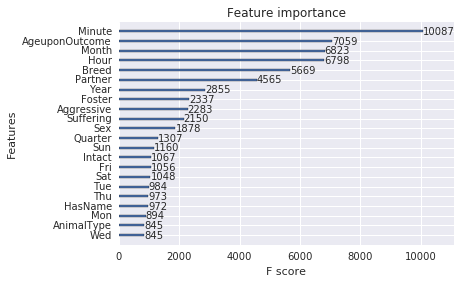

In [450]:
xgb_estimator = xgb_estimator.fit(X_train, y_train)
from xgboost import plot_importance

plot_importance(xgb_estimator)

In [386]:
xgb_pred = xgb_estimator.predict_proba(X_test)

In [387]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

rf_param_grid = dict(
    n_estimators = np.arange(80, 150, 10),
    max_depth = np.arange(8, 20),
)
grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, scoring='log_loss', verbose=True, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train).best_score_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  2.5min finished


-0.75835911330153627

In [406]:
rf_estimator = grid_search.best_estimator_

In [419]:
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 140}

In [479]:
score = cross_val_score(rf_estimator.set_params(criterion='gini'), X_train, y_train, cv=5, scoring='log_loss')
print('score mean: {:0.6f}, score std: {:0.6f}'.format(score.mean(), score.std()))

score mean: -0.744748, score std: 0.003568


In [456]:
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split

from scipy.optimize import minimize
from sklearn.calibration import CalibratedClassifierCV

def fn(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    xgb_pred = XGBClassifier(**xbg_grid_search.best_params_).fit(X_train, y_train).predict_proba(X_test)
    rf_pred = RandomForestClassifier(**grid_search.best_params_, random_state=42).fit(X_train, y_train).predict_proba(X_test)
    xgb_calib_pred = CalibratedClassifierCV(XGBClassifier(**xbg_grid_search.best_params_), cv=10, method='isotonic').fit(X_train, y_train).predict_proba(X_test)
    rf_calib_pred = CalibratedClassifierCV(RandomForestClassifier(**grid_search.best_params_, random_state=42), cv=10, method='isotonic').fit(X_train, y_train).predict_proba(X_test)
    
    y_pred = (xgb_pred + rf_calib_pred)/2
    print("xgb_pred log_loss: {}".format(log_loss(y_test, xgb_pred)))
    print("rf_pred log_loss: {}".format(log_loss(y_test, rf_pred)))
    print("xgb_calib_pred log_loss: {}".format(log_loss(y_test, xgb_calib_pred)))
    print("rf_calib_pred log_loss: {}".format(log_loss(y_test, rf_calib_pred)))
    print("y_pred log_loss: {}".format(log_loss(y_test, y_pred)))
    
    def target_fn(x):
        return log_loss(y_test, x[0]*xgb_calib_pred + x[1]*rf_calib_pred)

    def norm_consraint(x):
        return np.sum(x) - 1

    xopt = minimize(target_fn, [1/2]*2, bounds=[[0, 1] for i in range(2)], constraints=({'type': 'eq', 'fun': norm_consraint}), tol=1e-14)
    print("y_pred_w log_loss: {}".format(xopt.fun))
    return xopt.x
weigths = fn(X_train, y_train)

xgb_pred log_loss: 0.7225131235964357
rf_pred log_loss: 0.7516835678656014
xgb_calib_pred log_loss: 0.7170276848575293
rf_calib_pred log_loss: 0.7295822659274345
y_pred log_loss: 0.7126763904553242
y_pred_w log_loss: 0.7110365695141527


In [477]:
from sklearn.linear_model import LogisticRegression

def stacking(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    xgb_calib_est = CalibratedClassifierCV(XGBClassifier(**xbg_grid_search.best_params_), cv=10, method='isotonic').fit(X_train, y_train)
    xgb_calib_pred = xgb_calib_est.predict_proba(X_test)
    rf_calib_est = CalibratedClassifierCV(RandomForestClassifier(**grid_search.best_params_, random_state=42), cv=10, method='isotonic').fit(X_train, y_train)
    rf_calib_pred = rf_calib_est.predict_proba(X_test)
    
    X_pred_train = np.hstack((xgb_calib_est.predict_proba(X_train), rf_calib_est.predict_proba(X_train)))
    print(X_pred_train.shape)
    X_pred_test = np.hstack((xgb_calib_est.predict_proba(X_test), rf_calib_est.predict_proba(X_test)))
    return log_loss(y_test, XGBClassifier(**xbg_grid_search.best_params_).fit(X_pred_train, y_train).predict_proba(X_pred_test))

stacking(X_train, y_train)

(21383, 10)


1.4580230374687959

In [457]:
weigths

array([ 0.63189539,  0.36810461])

In [438]:
# from sklearn.ensemble import GradientBoostingClassifier

# gb_pred = GradientBoostingClassifier(n_estimators=90, max_depth=14).fit(X_train, y_train).predict_proba(X_test)

In [458]:
X_train.shape

(26729, 22)

In [459]:
xgb_pred = CalibratedClassifierCV(XGBClassifier(**xbg_grid_search.best_params_), cv=10, method='isotonic').fit(X_train, y_train).predict_proba(X_test)
rf_pred = CalibratedClassifierCV(RandomForestClassifier(**grid_search.best_params_, random_state=42), cv=10, method='isotonic').fit(X_train, y_train).predict_proba(X_test)

In [460]:
y_pred = weigths[0]*xgb_pred + weigths[1]*rf_pred
# y_pred = xgb_pred

In [461]:
submission = pd.DataFrame(index=test.index)
for i, outcome_type in enumerate(outcometype_encoder.classes_):
    submission[outcome_type] = y_pred[:, i]

In [462]:
submission.to_csv('pred.csv')